In [ ]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
#notify=Audio(url = url, autoplay = True)
notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [ ]:
S8_initial = 0.5994497992432309
S6_initial = 0.014276183725582573
S4_initial = 0.009826487256660566
S2_initial = 7.236564451939587e-11
S_initial = 1.2723395454343494e-14
Sp_initial = 2.3426047241510102e-07
V_initial = 2.3999806024835673

# Basic Discharge Test

In [ ]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": 0.0422,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S6 ion [g]": S6_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Standard Potential L [V]": 1.9,#1.9,#2.0,
        "Standard Potential M [V]": 1.95,#1.95,#2.0,
        "Standard Potential H [V]": 2.4,#2.35,#2.38,
        "Lower voltage cut-off [V]" : 1.9,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002
    }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        #dt_max = .1,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 5000#16950#3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))

## Basic Single Discharge Voltage Curve

In [ ]:
plt.plot(0.0422*sim.solution.t/3600, sim.solution["Terminal voltage [V]"].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

In [46]:
def plateaus(Es):
    try:
        EH0, EM0, EL0 = Es
        model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

        param = model.default_parameter_values
        param.update(
            {
                "Current function [A]": 0.0422,
                "Initial Condition for S8 ion [g]": S8_initial,
                "Initial Condition for S6 ion [g]": S6_initial,
                "Initial Condition for S4 ion [g]": S4_initial,
                "Initial Condition for S2 ion [g]": S2_initial,
                "Initial Condition for S ion [g]": S_initial,
                "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
                "Initial Condition for Terminal Voltage [V]": V_initial,
                "Standard Potential L [V]": EL0,#1.9,#2.0,
                "Standard Potential M [V]": EM0,#1.95,#2.0,
                "Standard Potential H [V]": EH0,#2.35,#2.38,
                "Lower voltage cut-off [V]" : 1.9,
                "Shuttle rate coefficient during discharge [s-1]": 0.0002
            }
        )


        sim = pybamm.Simulation(
            model,
            #experiment=experiment,
            parameter_values = param,
            solver=pybamm.CasadiSolver(
                atol=1e-6,
                rtol=1e-3,
                dt_max = 1,
                extra_options_setup={"max_step_size": 0.1}, 
                max_step_decrease_count = 15,
            ),
        )
        hours = 4.8
        time_in_seconds = 5000#16950#3600*hours
        sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
        capacity = 0.0422*sim.solution.t/3600
        voltage = sim.solution["Terminal voltage [V]"].entries
    except:
        capacity = 0
        voltage = 0
    return (capacity, voltage, Es)

In [47]:
my_iterable = [(2.4,2.1,1.9),
              (2.4,1.95,1.9),
              (2.35,2.1, 1.9),
              (2.35,1.95, 1.9),
              (2.3,2.1, 2),
              (2.3,1.95, 1.9),]

sim_data = Parallel(n_jobs=-1)(delayed(plateaus)(i) for i in my_iterable)

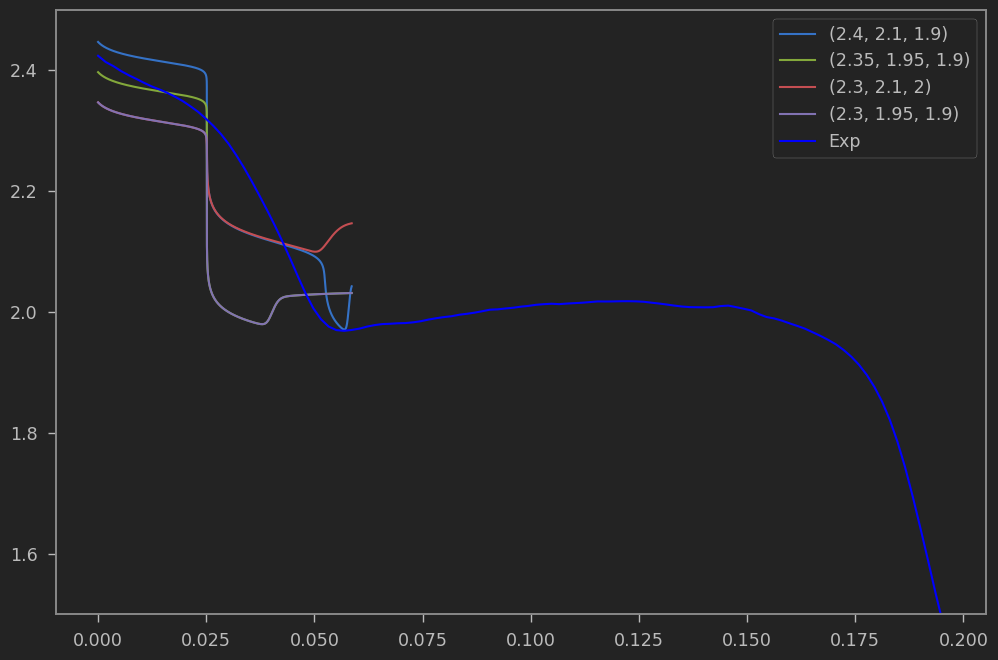

In [53]:
legend = []
for sim in sim_data:
    if type(sim[0]) != int:
        plt.plot(sim[0], sim[1])
        legend.append(str(sim[2]))

plt.ylim([1.5,2.5])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], color = 'blue')
legend.append('Exp')
plt.legend(legend)

In [45]:
len(sim_data)

3

# Basic Single Discharge Resistance Curve

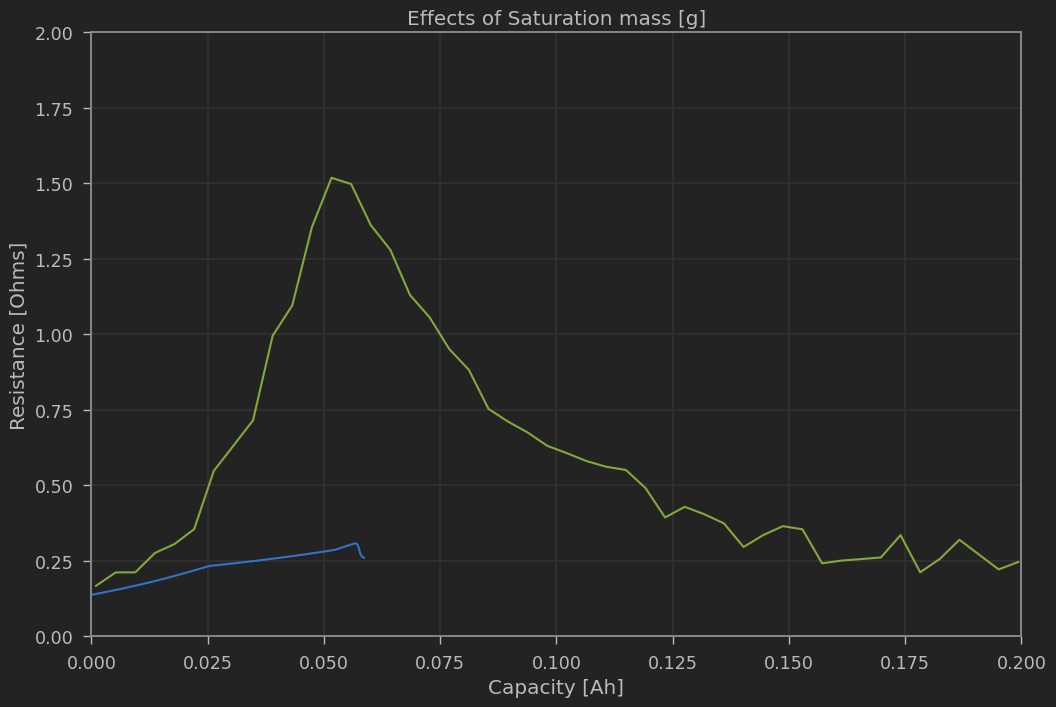

In [26]:
sigma_0 = 2e-3
l =  4e-5
A = 0.15

capacity = .0422*sim.solution.t/3600
S6 = sim.solution['S6 [g]'].entries
S4 = sim.solution['S4 [g]'].entries
S2 = sim.solution['S2 [g]'].entries
S1 = sim.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 + (1/6)*S6
b = 1.319e-2
sigma = sigma_0 - b*(Li)
R = l/(A*sigma)
plt.plot(capacity,R)


filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

plt.ylim([0,2])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)


# Discharge Rate-Capacity Dependence Test

In [78]:
current_list = [0.0211, 0.0422, 0.0844, 0.1]
data = {}
for current in current_list:
    model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
    param = model.default_parameter_values
    param.update(
        {
            "Current function [A]": current,
            "Initial Condition for S8 ion [g]": S8_initial,
            "Initial Condition for S6 ion [g]": S6_initial,
            "Initial Condition for S4 ion [g]": S4_initial,
            "Initial Condition for S2 ion [g]": S2_initial,
            "Initial Condition for S ion [g]": S_initial,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            "Standard Potential L [V]": 1.9,#2.0,
            "Standard Potential M [V]": 1.95,#2.0,
            "Standard Potential H [V]": 2.35,#2.38,
            "Lower voltage cut-off [V]" : 1.9
        }
    )
    sim = pybamm.Simulation(
        model,
        #experiment=experiment,
        parameter_values = param,
        solver=pybamm.CasadiSolver(
            atol=1e-6,
            rtol=1e-3,
            dt_max = 10,
            #extra_options_setup={"max_step_size": 0.1}, 
            max_step_decrease_count = 15,
        ),
    )
    hours = 4.8
    time_in_seconds = 600/current#16000#3600*hours
    sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
    capacity = current*sim.solution.t/3600, 
    voltage = sim.solution["Terminal voltage [V]"].entries
    data[str(current)] = (capacity, voltage)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

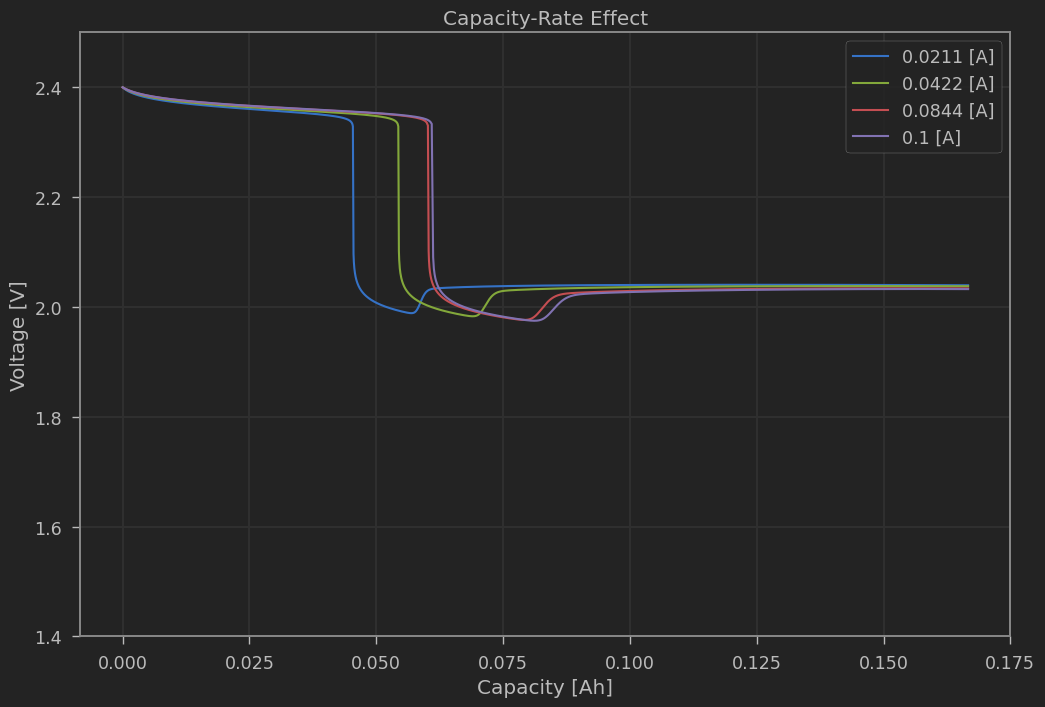

In [79]:
legend = []
for key in data.keys():
    capacity, voltage = data[key]
    plt.plot(capacity[0], voltage)
    legend.append(key + ' [A]')
plt.ylim([1.4,2.5])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Capacity-Rate Effect')
plt.legend(legend)
plt.grid(True)

In [98]:
current = 0.0422
sat = 0.00001

model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S6 ion [g]": S6_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Standard Potential L [V]": 1.9,#2.0,
        "Standard Potential M [V]": 1.95,#2.0,
        "Standard Potential H [V]": 2.35,#2.38,
        "Lower voltage cut-off [V]" : 1.8,
        "S saturation mass [g]": sat
    }
)
sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        dt_max = .001,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 600/current#16000#3600*hours
sim.solve([0,18000])#np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
capacity = current*sim.solution.t/3600
voltage = sim.solution["Terminal voltage [V]"].entries

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

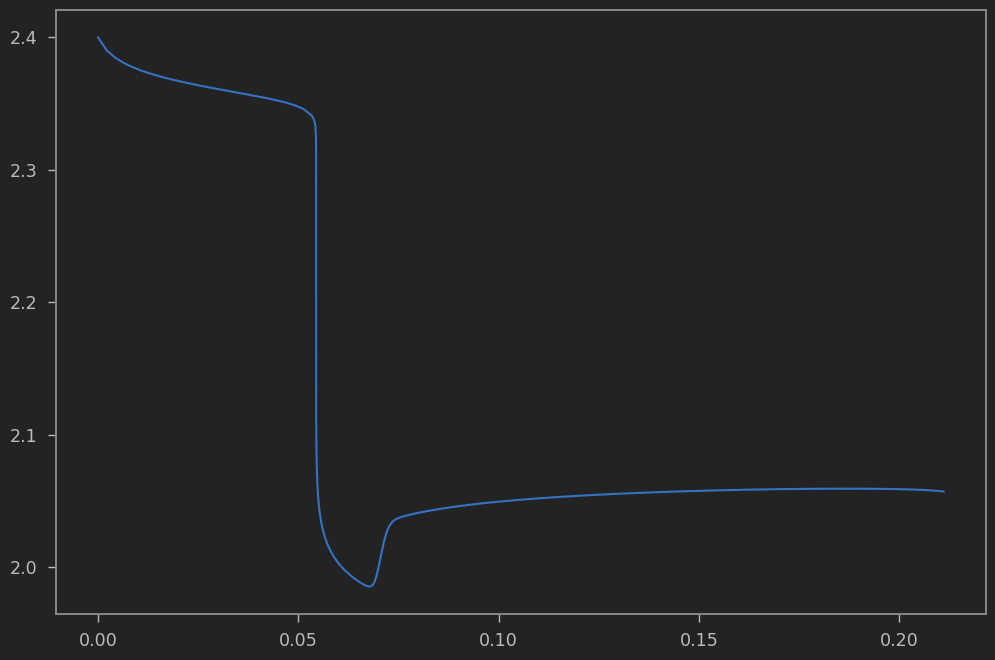

In [99]:
plt.plot(capacity, voltage)

In [28]:

S8_initial = 0.5994497992432309
S6_initial = 0.014276183725582573
S4_initial = 0.009826487256660566
S2_initial = 7.236564451939587e-11
S_initial = 1.2723395454343494e-14
Sp_initial = 2.3426047241510102e-07
V_initial = 2.3999806024835673
current = 0.0422
sat = 0.00001

model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S6 ion [g]": S6_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Standard Potential L [V]": 1.9,#2.0,
        "Standard Potential M [V]": 1.95,#2.0,
        "Standard Potential H [V]": 2.35,#2.38,
        "Lower voltage cut-off [V]" : 1.8,
        "S saturation mass [g]": sat
    }
)
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=param,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1},
    ),
)
# step up to tf in steps of ts
tf = 18370
ts = 100
t = 0
max_count = 10
count = 0
# take a small initial 60s step 
sim.step(60)
t = sim.solution.t[-1]
condition = True
npts = 10
while t < tf:
    try:
        sim.step(ts,npts=npts)
        
    except (RuntimeError,pybamm.SolverError):
        count = count + 1
        ts = ts / 2 
    t = sim.solution.t[-1]
    if count == 25:
        break
    if t > 5000 and condition:
        count = 0
        ts = 1000
        condition = False

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

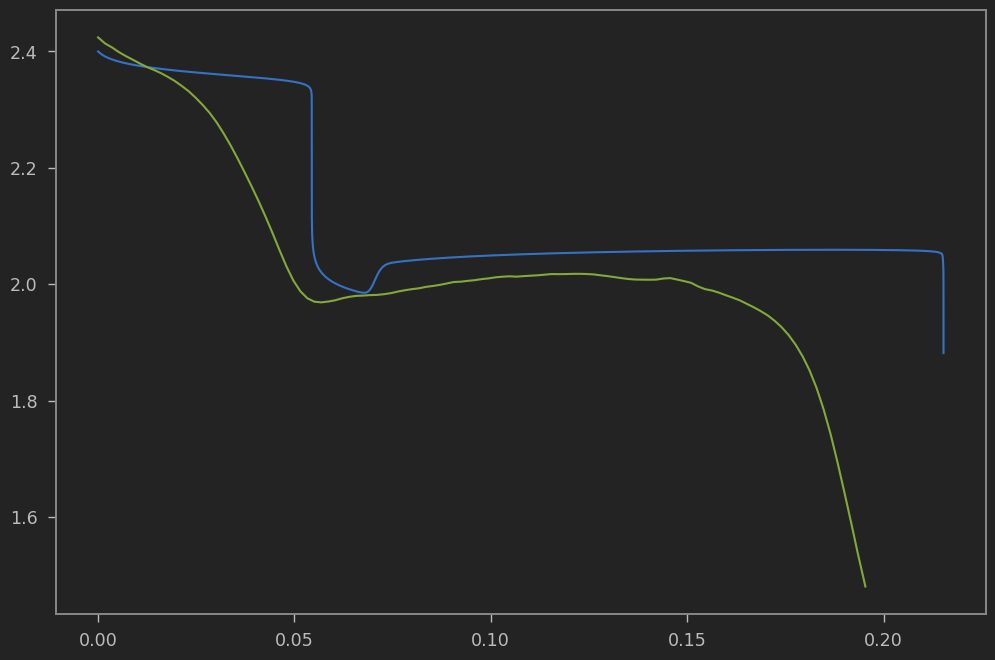

In [29]:
capacity = current*sim.solution.t/3600
voltage = sim.solution["Terminal voltage [V]"].entries
plt.plot(capacity, voltage)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

In [69]:
sims = []
for loc in [-100000,-50000,-10000,-1000]:

    S8_initial_cha = sim.solution["S8 [g]"].entries[loc]
    S6_initial_cha = sim.solution["S6 [g]"].entries[loc]
    S4_initial_cha = sim.solution["S4 [g]"].entries[loc]
    S2_initial_cha = sim.solution["S2 [g]"].entries[loc]
    S_initial_cha = sim.solution["S [g]"].entries[loc]
    Sp_initial_cha = sim.solution["Precipitated Sulfur [g]"].entries[loc]
    V_initial_cha = sim.solution["Terminal voltage [V]"].entries[loc]
    
    current = 0.0422/(-2)
    sat = 0.00001

    model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
    param_cha = model_cha.default_parameter_values
    param_cha.update(
        {
            "Current function [A]": current,
            "Initial Condition for S8 ion [g]": S8_initial_cha,
            "Initial Condition for S6 ion [g]": S6_initial_cha,
            "Initial Condition for S4 ion [g]": S4_initial_cha,
            "Initial Condition for S2 ion [g]": S2_initial_cha,
            "Initial Condition for S ion [g]": S_initial_cha,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cha,
            "Initial Condition for Terminal Voltage [V]": V_initial_cha,
            "Standard Potential L [V]": 1.9,#2.0,
            "Standard Potential M [V]": 1.95,#2.0,
            "Standard Potential H [V]": 2.35,#2.38,
            "Lower voltage cut-off [V]" : 1.8,
            "S saturation mass [g]": sat
        }
    )
    # Set up and solve simulation
    sim_cha = pybamm.Simulation(
        model_cha,
        parameter_values=param_cha,
        solver=pybamm.CasadiSolver(
            atol=1e-6, 
            rtol=1e-3, 
            extra_options_setup={"max_step_size": 0.1},
            dt_max = .1,
            #extra_options_setup={"max_step_size": 0.1}, 
            max_step_decrease_count = 17,
        ),
    )
    sim_cha.solve([0,4000])
    sims.append(sim_cha)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.53629 and h = 1.07288e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.48823 and h = 4.76837e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.54521 and h = 1.3411e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.56172 and h = 2.14577e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ..

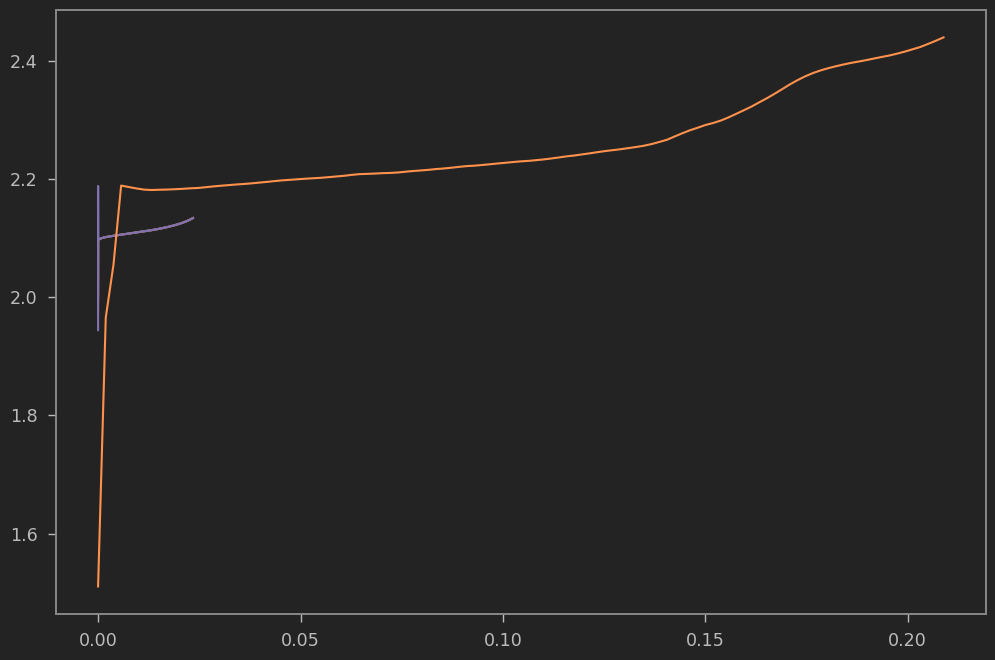

In [70]:
for sim_cha in sims:
    capacity_cha = -current*sim_cha.solution.t/3600
    voltage_cha = sim_cha.solution["Terminal voltage [V]"].entries
    plt.plot(capacity_cha, voltage_cha)
    

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

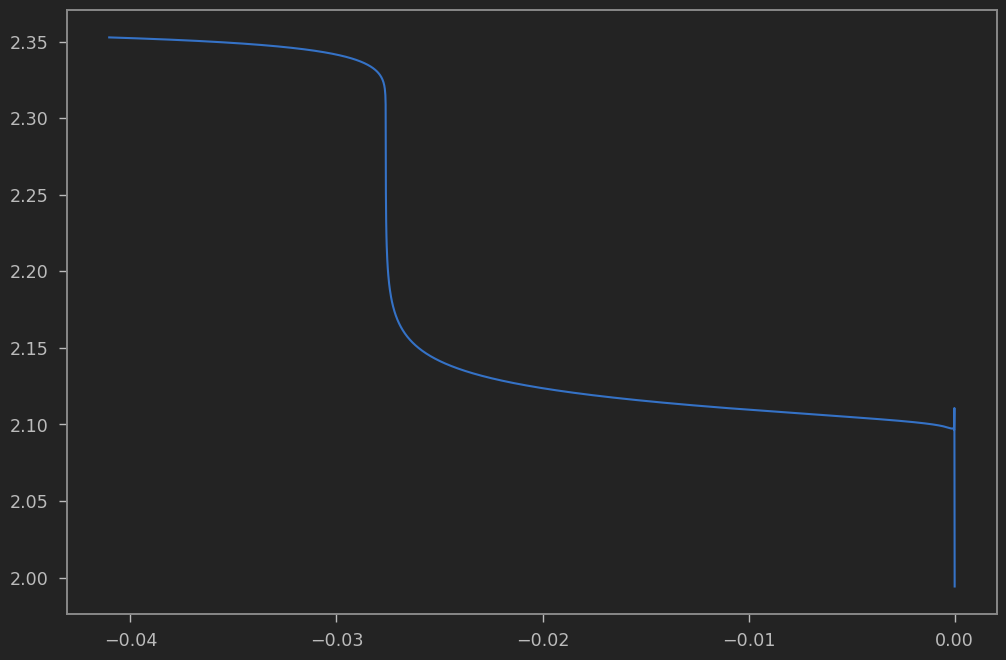

In [59]:
sim_cha = sims[1]
capacity_cha = current*sim_cha.solution.t/3600
voltage_cha = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity_cha, voltage_cha)

In [11]:
S8_initial_cha = sim.solution["S8 [g]"].entries[loc]
S6_initial_cha = sim.solution["S6 [g]"].entries[loc]
S4_initial_cha = sim.solution["S4 [g]"].entries[loc]
S2_initial_cha = sim.solution["S2 [g]"].entries[loc]
S_initial_cha = sim.solution["S [g]"].entries[loc]
Sp_initial_cha = sim.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial_cha = sim.solution["Terminal voltage [V]"].entries[loc]

current = 0.0422/(-2)
sat = 0.00001

model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cha,
        "Initial Condition for S6 ion [g]": S6_initial_cha,
        "Initial Condition for S4 ion [g]": S4_initial_cha,
        "Initial Condition for S2 ion [g]": S2_initial_cha,
        "Initial Condition for S ion [g]": S_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cha,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Standard Potential L [V]": 1.9,#2.0,
        "Standard Potential M [V]": 1.95,#2.0,
        "Standard Potential H [V]": 2.35,#2.38,
        "Lower voltage cut-off [V]" : 1.5,
        "S saturation mass [g]": sat
    }
)
# Set up and solve simulation
sim_cha = pybamm.Simulation(
    model_cha,
    parameter_values=param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1},
    ),
)
sim_cha.solve([])

In [66]:
loc = 1000
V_initial_cha = sim.solution["Terminal voltage [V]"].entries[loc]
V_initial_cha


2.050320171838581